In [195]:
import os
import pandas as pd 
import datetime as dt
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
from pdb import set_trace as keyboard
import numpy as np
import matplotlib.pyplot as plt

In [196]:
stockTicker = 'TIET4'
stockType = 'Preferencial' 
nYears = 1.
endDate = dt.datetime(2019, 8, 1)
startDate = endDate - dt.timedelta(days=int(365*nYears))

In [197]:
yf.pdr_override()

In [198]:
endDate_str = endDate.strftime("%Y-%m-%d")
startDate_str = startDate.strftime("%Y-%m-%d")
stockDF = pdr.get_data_yahoo(stockTicker + '.SA', start=startDate_str, end=endDate_str)[::-1]['Close']
stockDF_priceEv = stockDF/stockDF.iloc[-1]
stockDF.head(5)

[*********************100%***********************]  1 of 1 downloaded


Date
2019-08-01    2.455
2019-07-31    2.445
2019-07-30    2.435
2019-07-29    2.435
2019-07-26    2.415
Name: Close, dtype: float64

In [199]:
import requests
from bs4 import BeautifulSoup
req = requests.get('https://br.advfn.com/bolsa-de-valores/bovespa/%s/dividendos' % stockTicker)
if req.status_code == 200:
    print('Requisição bem sucedida!')
    content = req.content

Requisição bem sucedida!


In [200]:
soup = BeautifulSoup(content, 'html.parser')

In [201]:
table = []
monthDict={'Jan':1, 'Fev':2, 'Mar':3, 'Abr':4, 'Mai':5, 'Jun':6, 'Jul':7, 'Ago':8, 'Set':9, 'Out':10, 'Nov':11, 'Dez':12}

contents_str = str(soup.find_all(class_="Element TableElement DividendsTableElement")[0]).split('</tr>')
for i in contents_str[1:]:
    
    try:
        elements = i.split('"String Column2">')
        temp = elements[1].split('</td><td class="String Column3">Proventos em dinheiro</td><td class="String Column4">')
        
        day, month, year = temp[0].split(' ')
        paymentDate = dt.datetime(int(year), monthDict[month], int(day))


        temp2 = temp[1].split('</td><td class="Numeric Column5 ColumnLast"')

        stockType = temp2[0]

        dividend = float(temp2[1].split('>')[1].split('</td')[0].replace(',', '.'))
        #keyboard()

        table.append([paymentDate, stockType, dividend])
    except:
        continue ##########Check
    
dividends_df = pd.DataFrame(np.array(table), columns=['PaymentDate', 'StockType', 'Dividend'])
dividends_df_stocktype = dividends_df[dividends_df['StockType'] == stockType]

#dividends_df[dividends_df['StockType'] == 'Ordinária']

In [202]:
dividends_df_grouped = dividends_df[dividends_df['StockType'] == stockType][['PaymentDate', 'Dividend']].groupby(['PaymentDate']).min()
dividends_df_grouped[::-1].head()

,Dividend
PaymentDate,
2019-07-24,0.032275
2018-11-22,0.020020
2018-10-10,0.052709
2018-07-25,0.024235
2018-01-10,0.006315


In [203]:
evolution = [0.]
stockDates = [pd.Timestamp(i).to_pydatetime() for i in stockDF.index]

lastPrice  = stockDF.iloc[-1]
addDiv = False
for date in stockDF.index[::-1][1:]:
    closePrice = stockDF[date]
    if date in dividends_df_grouped.index:
        addDiv = True
        dividendReceived = dividends_df_grouped.loc[date]['Dividend']
        
    patrimonialDiff = (closePrice - lastPrice)
    if addDiv:
        patrimonialDiff += dividendReceived
    
    #keyboard()
    evolution.append((1. + evolution[-1]) * (1. + patrimonialDiff / lastPrice) - 1.)
    addDiv = False
    lastPrice  = closePrice

0.2059141369486197 0.26577363170499146


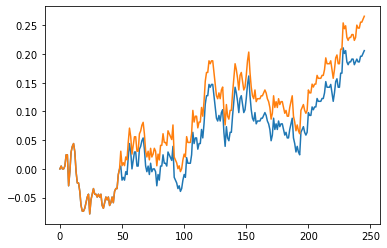

In [204]:
print(stockDF_priceEv.values[::-1][-1]-1, evolution[-1])
plt.plot(stockDF_priceEv.values[::-1] - 1.)
plt.plot(evolution)